<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Случайный-лес:" data-toc-modified-id="Случайный-лес:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес:</a></span></li><li><span><a href="#Стохастический-градиентный-бустинг-без-изменения-гиперпараметров" data-toc-modified-id="Стохастический-градиентный-бустинг-без-изменения-гиперпараметров-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Стохастический градиентный бустинг без изменения гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#С-помощью-библиотеки-LightGBM:" data-toc-modified-id="С-помощью-библиотеки-LightGBM:-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>С помощью библиотеки LightGBM:</a></span></li><li><span><a href="#С-помощью-библиотеки-Catboost:" data-toc-modified-id="С-помощью-библиотеки-Catboost:-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>С помощью библиотеки Catboost:</a></span></li></ul></li><li><span><a href="#Стохастический-градиентный-бустинг-с-подбором-гиперпараметров" data-toc-modified-id="Стохастический-градиентный-бустинг-с-подбором-гиперпараметров-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Стохастический градиентный бустинг с подбором гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#С-помощью-библиотеки-LightGBM:" data-toc-modified-id="С-помощью-библиотеки-LightGBM:-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>С помощью библиотеки LightGBM:</a></span></li><li><span><a href="#С-помощью-библиотеки-Catboost:" data-toc-modified-id="С-помощью-библиотеки-Catboost:-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>С помощью библиотеки Catboost:</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель проекта:** построение модели машинного обучения для прогнозирования количества заказов такси на следующий час. Модель будет использована для оптимизации количества такси в периоды пиковых нагрузок в аэропортах.

**Исходные данные**: исторические данные о заказах такси в аэропортах.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка данных

In [4]:
import pandas as pd
import lightgbm as ltb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [5]:
data = pd.read_csv('/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В данных два столбца: время заказа такси с шагом 10 минут (тип object), и количество заказов (целочисленный тип). Пропусков в исходных данных нет, база содержит 26 496 наблюдений.

Поскольку наша цель - прогнозирование количества заказов на следующий час, ресемплируем данные с шагом в один час:

In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


После подготовки наши данные о количестве заказов такси в аэропортах представляют собой временной ряд с шагом в 1 час с 1 марта по 31 августа 2018 года.

## Анализ данных

Сделаем декомпозицию нашего временного ряда на тренд, сезонную и случайную составляющие.

In [9]:
decomposed = seasonal_decompose(data)

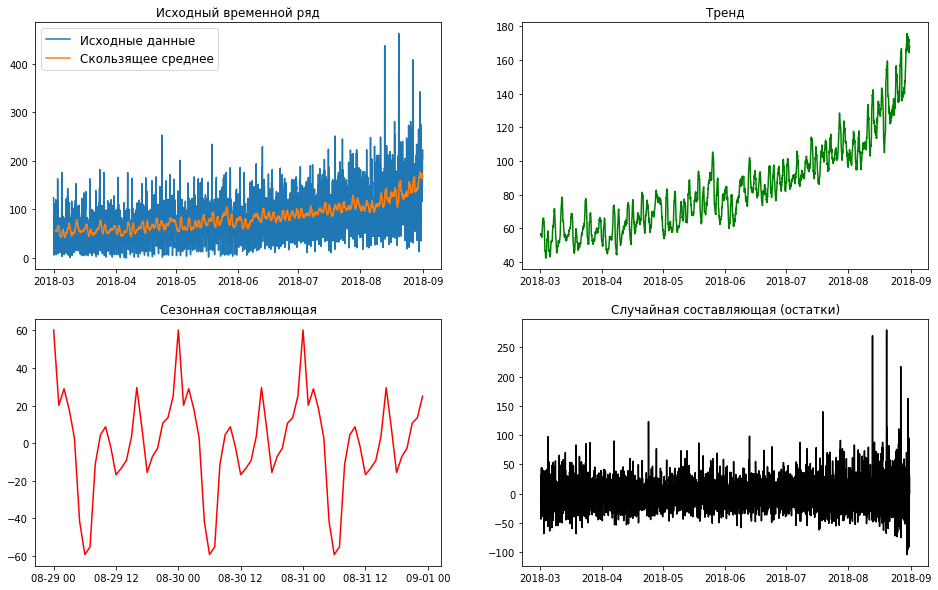

In [10]:
fig,axs = plt.subplots(2, 2, figsize = (16,10))
axs[0,0].plot(data, label = 'Исходные данные')
axs[0,0].plot(data.rolling(24).mean(), label = 'Скользящее среднее')
axs[0,0].set_title('Исходный временной ряд')
axs[0,0].legend(fontsize = 12)

axs[0,1].plot(decomposed.trend, color = 'g')
axs[0,1].set_title('Тренд')

axs[1,0].plot(decomposed.seasonal['2018-08-29': '2018-08-31'], color = 'r')
axs[1,0].set_title('Сезонная составляющая')

axs[1,1].plot(decomposed.resid, color = 'k')
axs[1,1].set_title('Случайная составляющая (остатки)')
plt.show()

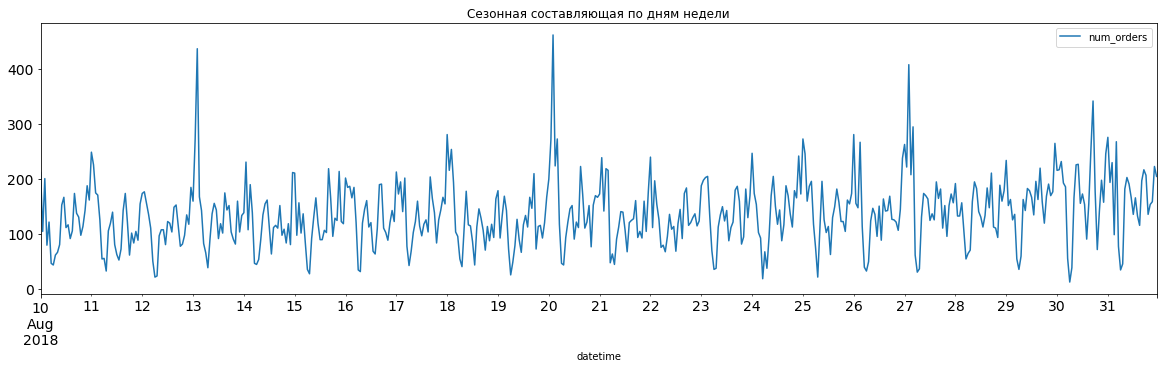

In [11]:
data['2018-08-10': '2018-08-31'].plot(figsize = (20,5), title = 'Сезонная составляющая по дням недели', fontsize = 14)
plt.show()

Построим также график автокорреляции:

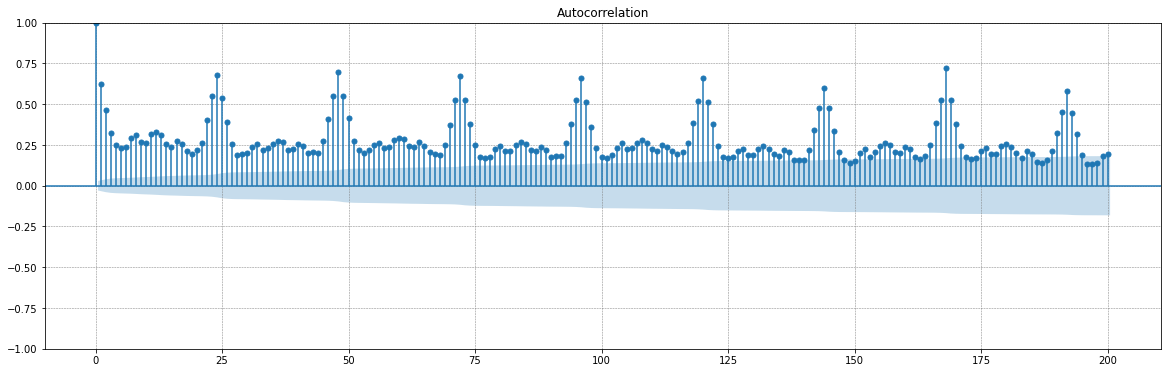

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20,6))
plot_acf(data.values, lags=200, ax=ax)
ax.grid(which="major", color="grey", linestyle="--", linewidth=0.5)
plt.show()

Статистические показатели по количеству вызовов:

In [13]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Для примера проанализируем отдельно один из пиковых дней - понедельник, 20 августа 2018 года:

In [14]:
data.loc['2018-08-20']

,num_orders
datetime,
2018-08-20 00:00:00,200
2018-08-20 01:00:00,272
2018-08-20 02:00:00,462
2018-08-20 03:00:00,224
2018-08-20 04:00:00,273
2018-08-20 05:00:00,118
2018-08-20 06:00:00,47
2018-08-20 07:00:00,44
2018-08-20 08:00:00,94


### Вывод
По графикам можно сделать следующие выводы: тренд по количеству заказов такси с марта по сентябрь 2018 года - возрастающий. В сезонной компоненте есть две составляющие: в зависимости от времени суток (в ночное время такси вызывают чаще, это и понятно - общественный транспорт ночью не ходит или ходит значительно реже) и в зависимости от дня недели (заметные пики - по понедельникам, связаны с деловой активностью в начале недели). 

Медианное количество вызовов в час - 78, максимальное - 462, почти в 6 раз больше - такие нагрузки характерны для ночи с воскресенья на понедельник.

## Обучение моделей

В качестве признаков для обучения модели будем использовать следующие:
- год
- месяц
- день
- час
- ден недели
- сдвиги нашего временного ряда, лаг для которых подберём с помощью функции
- скользящее среднее, размер окна для которого также подберём ниже

В качестве метрики для оценки качества используем среднеквадратичную ошибку RMSE.

Напишем функцию для создания признаков:

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Функция для подсчёта RMSE:

In [16]:
def RMSE (target, predictions): 
    return round(mean_squared_error(target, predictions)**0.5, 2)
rmse_score = make_scorer(RMSE, greater_is_better = False)

Функция для подбора оптимального сочетания лага и окна скользящего среднего на примере модели линейной регрессии:

In [18]:
best_RMSE = 100
best_lag = 1
best_rolling_size = 1
for lag in range(0, 170, 24):
    for rolling_mean_size in range(1, 25):
        data = data[['num_orders']]
        make_features(data, lag, rolling_mean_size)
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()
        target_train = train['num_orders']
        features_train = train.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train)
        if RMSE(target_train, predictions_train) < best_RMSE:
            best_RMSE = RMSE(target_train, predictions_train)
            best_lag = lag
            best_rolling_size = rolling_mean_size        
print('Лучшие показатели обучения линейной регрессии: \n лаг -', best_lag, '\n размер окна -', best_rolling_size, 
       '\n RMSE тренировочной выборки = {}'.format(best_RMSE))

Лучшие показатели обучения линейной регрессии: 
 лаг - 168 
 размер окна - 15 
 RMSE тренировочной выборки = 20.36


Подготовим данные, используя полученные оптимальные сочетания параметров для остальных моделей:

In [19]:
data = data[['num_orders']] # удалим признаки, которые остались после последнего шага работы функции
make_features(data, best_lag, best_rolling_size)
data.head(3)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)
print(features_train.shape)
print(features_test.shape)

(3806, 171)
(442, 171)


___
### Модель линейной регрессии
(только обучим и сохраним модель, RMSE её на тренировочной выборке уже известна, тестировать будем в следующем разделе):

In [21]:
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

LinearRegression()

___
### Случайный лес:

In [22]:
forest = RandomForestRegressor(random_state=1)
params = {'max_depth':range(1,5),
          'n_estimators': range(10,100,10)}
random_forest = RandomizedSearchCV(forest, params, random_state=1, 
                                   scoring = rmse_score, cv = TimeSeriesSplit(n_splits=8))
random_forest.fit(features_train, target_train)
print('Параметры лучшего случайного леса', random_forest.best_params_)
print('Лучшая модель случайного леса показала RMSE', round(-random_forest.best_score_, 2))

Параметры лучшего случайного леса {'n_estimators': 80, 'max_depth': 4}
Лучшая модель случайного леса показала RMSE 23.22


___
### Стохастический градиентный бустинг без изменения гиперпараметров
#### С помощью библиотеки LightGBM:

In [23]:
ltb_default = ltb.LGBMRegressor(random_state = 1, metric = 'rmse')
ltb_default.fit(features_train, target_train)
ltb_default_train_predictions = ltb_default.predict(features_train)

ltb_default_scores = cross_val_score(ltb_default, features_train, target_train, 
                                     scoring = rmse_score, cv = TimeSeriesSplit(n_splits=8))
print('Средняя оценка RMSE дефолтной модели LightGBM:', - round(ltb_default_scores.mean(), 2))

Средняя оценка RMSE дефолтной модели LightGBM: 22.63


#### С помощью библиотеки Catboost:

In [24]:
cat_default = CatBoostRegressor(random_seed = 1)
cat_default.fit(features_train, target_train,verbose=False)

In [25]:
cat_default.best_score_['learn']

{'RMSE': 9.015233316030105}

___
### Стохастический градиентный бустинг с подбором гиперпараметров
#### С помощью библиотеки LightGBM:

In [26]:
params = {'max_depth':range(1,10),
          'n_estimators': range(150,300,50),
          'learning_rate': [0.05,0.1,0.2,0.5]}
ltb_param = RandomizedSearchCV(ltb_default, params, random_state=1, 
                                   scoring = rmse_score, cv = TimeSeriesSplit(n_splits=8))
ltb_param.fit(features_train, target_train)
print('Параметры лучшей модели LightGBM', ltb_param.best_params_)
print('Лучшая модель LightGBM показала RMSE', round(-ltb_param.best_score_, 2))

Параметры лучшей модели LightGBM {'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.2}
Лучшая модель LightGBM показала RMSE 22.38


#### С помощью библиотеки Catboost:

In [27]:
params = {'depth':range(1,10),
          'n_estimators': range(150,300,50),
          'learning_rate': [0.05,0.1,0.2,0.5]}
cat_param = RandomizedSearchCV(cat_default, params, random_state=1, 
                                   scoring = rmse_score, cv = TimeSeriesSplit(n_splits=8))
cat_param.fit(features_train, target_train, verbose=False)
print('Параметры лучшей модели Catboost', cat_param.best_params_)
print('Лучшая модель Catboost показала RMSE', round(-cat_param.best_score_, 2))

Параметры лучшей модели Catboost {'n_estimators': 150, 'learning_rate': 0.05, 'depth': 5}
Лучшая модель Catboost показала RMSE 22.03


In [28]:
train_result_table = pd.Series([best_RMSE, -random_forest.best_score_, -ltb_default_scores.mean(), 
                              cat_default.best_score_['learn']['RMSE'], -ltb_param.best_score_, -cat_param.best_score_],
                               index = ['Линейная регрессия', 'Cлучайный лес', 'Дефолтный LGBM', 'Дефолтный Catboost',
                                    'LGBM с гиперпараметрами', 'Catboost с гиперпараметрами'])
print('RMSE моделей на тренировочной выборке: \n')
print(round(train_result_table, 1).sort_values())                         

RMSE моделей на тренировочной выборке: 

Дефолтный Catboost              9.0
Линейная регрессия             20.4
Catboost с гиперпараметрами    22.0
LGBM с гиперпараметрами        22.4
Дефолтный LGBM                 22.6
Cлучайный лес                  23.2
dtype: float64


## Тестирование

Для тестирования выберем 4 лучшие по результатам обучения модели:
- дефолтный Catboost
- линейная регрессия
- Catboost с гиперпараметрами: количество деревьев - 150, максимальная глубина дерева -  1, скорость обучения - 0.2
- LGBM с гиперпараметрами: количество деревьев - 150, максимальная глубина дерева -  5, скорость обучения - 0.05

In [29]:
def model_test (model, name):
    test_predictions = model.predict(features_test)
    residuals = target_test - test_predictions
    test_RMSE = RMSE(target_test, test_predictions)
    fig,axs = plt.subplots(2, 1, figsize = (20,10))
    axs[0].plot(target_test)
    axs[0].plot(target_test.index, test_predictions)
    axs[0].set_title(name)
    
    axs[1].scatter(target_test.index, residuals)
    axs[1].set_title('График остатков')

    plt.show()
    print('RMSE модели {} на тестовой выборке:'.format(name), test_RMSE)

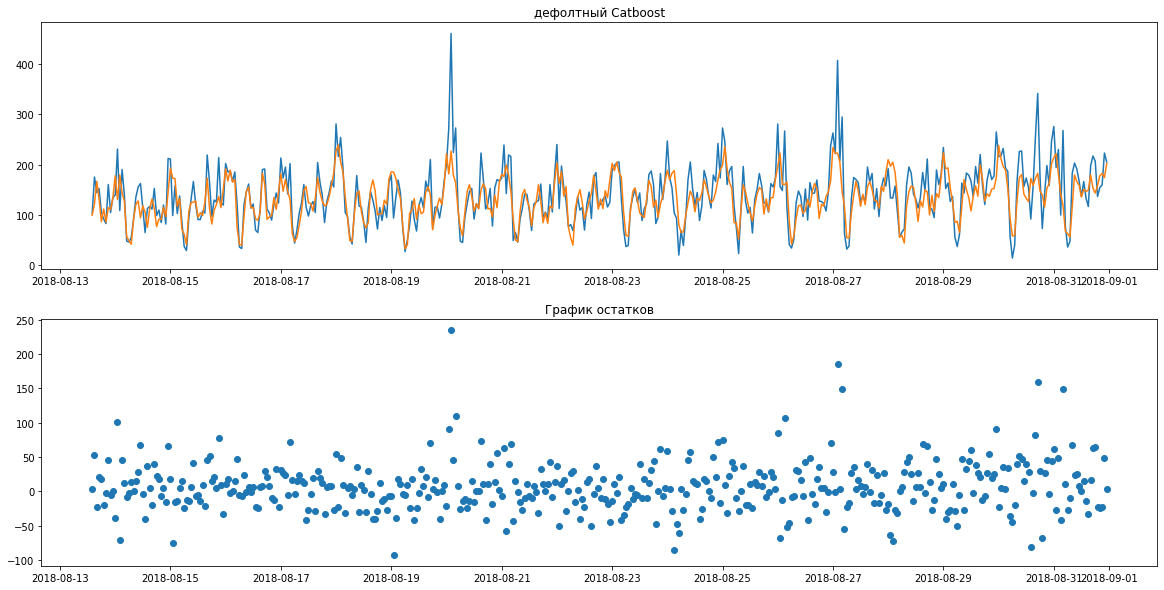

RMSE модели дефолтный Catboost на тестовой выборке: 37.47


In [30]:
model_test(cat_default, 'дефолтный Catboost')

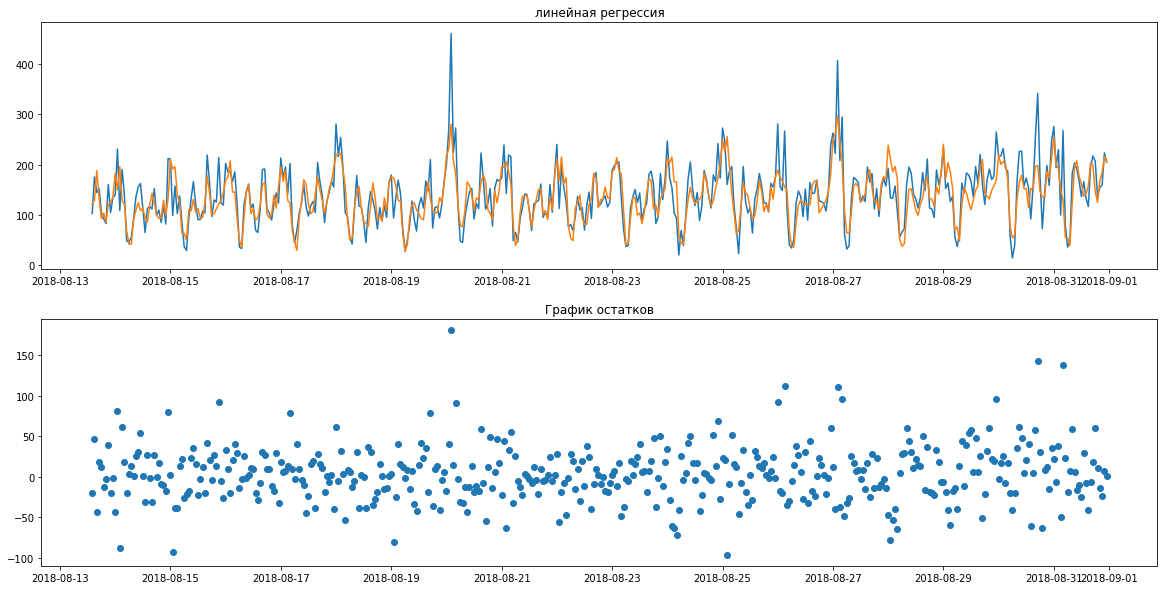

RMSE модели линейная регрессия на тестовой выборке: 34.52


In [35]:
model_test(linear_model, 'линейная регрессия')

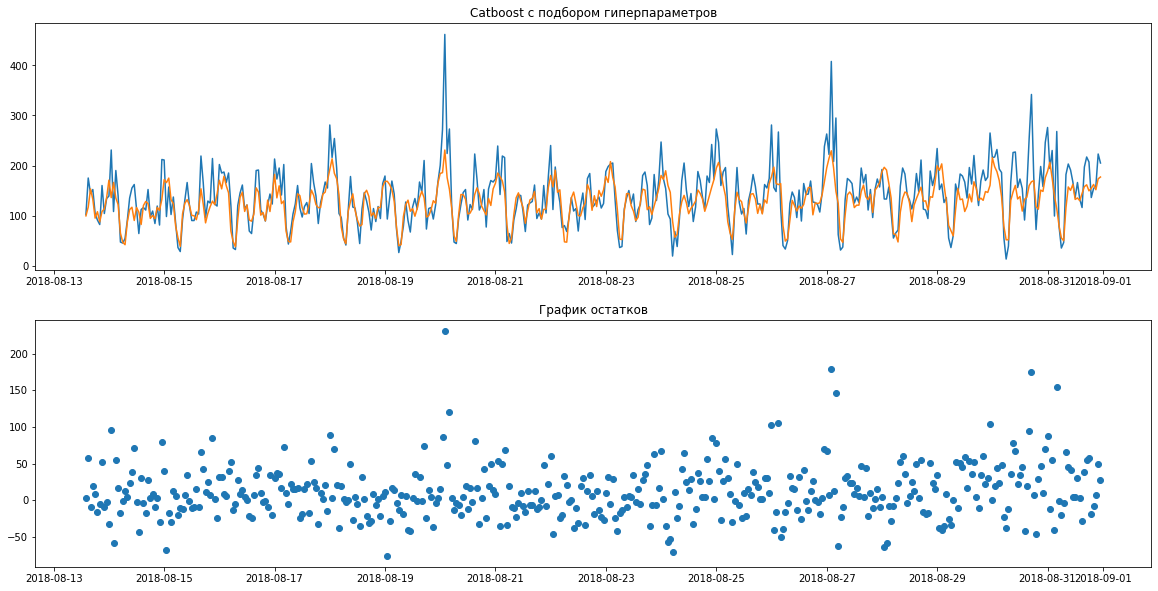

RMSE модели Catboost с подбором гиперпараметров на тестовой выборке: 38.73


In [32]:
model_test(cat_param, 'Catboost с подбором гиперпараметров')

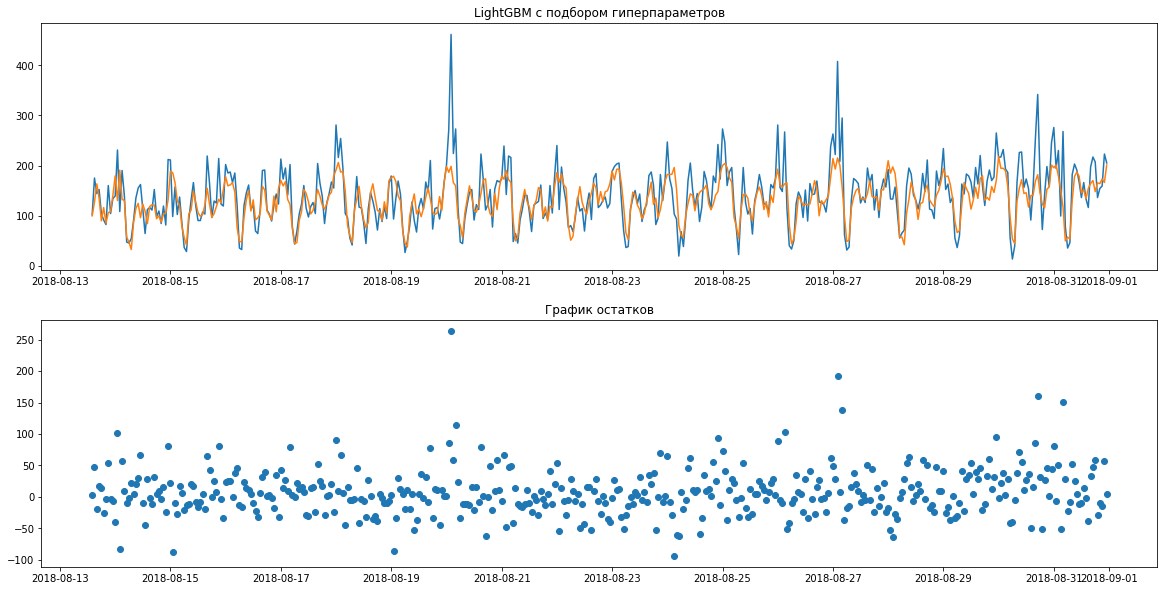

RMSE модели LightGBM с подбором гиперпараметров на тестовой выборке: 38.91


In [33]:
model_test(ltb_param, 'LightGBM с подбором гиперпараметров')

Сравним полученные результаты с прогнозом, построенным по предыдущему значению временного ряда:

In [34]:
pred_previous = target_test.shift().fillna(target_train.iloc[len(target_train)-1])
print("RMSE прогноза, построенного по предыдущему значению:", RMSE (target_test, pred_previous))

RMSE прогноза, построенного по предыдущему значению: 58.86


Все четыре выбранные нами модели показывают на тестовой выборке метрику RMSE меньше 48:
1. Линейная регрессия: 34.52
2. Дефолтная модель бустинга Catboost: 36.47 
3. Бустинг Catboost с подбором гиперпараметров: 38.73
4. Бустинг LightGBM с подбором гиперпараметров: 38.91

Все модели прошли проверку на адекватность: метрика RMSE построенных моделей значительно ниже, чем у прогноза, построенного по предыдущему значению ряда.

## Вывод

Перед нами была поставлена задача построения модели предсказания количества заказа такси на следующий час по имеющимся ретроспективным данным. Целевое значение метрики RMSE - не более 48. 

В ходе анализа выяснили, что данные о количестве заказов характеризуются возрастающим трендом и сезонной составляющей по дням недели и времени суток.

Для построения прогноза были использованы следующие модели:
- линейная регрессия
- случайный лес
- стохастический градиентный бустинг с использованием библиотек Catboost и LightGBM

Лучшие значения целевой метрики на тестовой выборке показала модель **линейной регрессии**: RMSE на тестовой выборке равна 34,5.  